# Hamiltonian Neural Network

### Importing Libraries

In [0]:
!pip install tensorflow==2.0.0-beta

In [0]:
import os
import gym
import math
import zipfile
import autograd
import scipy.integrate
solve_ivp  = scipy.integrate.solve_ivp
import autograd.numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation

### Data Generation Functions

In [0]:
from autograd import grad
import autograd.numpy as np

In [0]:
def fun_x(t, m=1.0, b=0.01, k=1.0, x_init=5):
    alpha = b/(2*m)
    omega = (abs(b**2-4*m*k))**0.5/(2*m)
    c1 = x_init
    c2 = (alpha*c1)/(omega)
    # print (alpha, omega, c1, c2)
    return np.exp(-1*alpha*t)*(c1*np.cos(omega*t) + c2*np.sin(omega*t))

In [0]:
def fun_v(t, m=1.0, b=0.01, k=1.0, x_init=5):
    grad_tanh = grad(fun_x)
    return grad_tanh(t, m, b, k, x_init)

In [0]:
def fun_a(t, m=1.0, b=0.01, k=1.0, x_init=5):
    grad_tanh = grad(fun_v)
    return grad_tanh(t, m, b, k, x_init)

In [0]:
'''
t_span - time span for data points
timescale - number of datapoints per second
noise_std - standard deviation of the noise (Gaussian Noise)
'''
def get_trajectory(t_span = [0,20], timescale  = 10, y0 = None, noise_std = 0.1, radius = None):
    if (y0 is None):
        y0 = (np.random.rand(1)*2-1)*5

    # spring_ivp = solve_ivp(fun = dynamics_fn, t_span = t_span, y0=y0, t_eval=t_eval, rtol=1e-10)
    q = []
    p = []
    dqdt = []
    dpdt = []
    c = []
    for i in range(t_span[0], t_span[1]):
        for j in range(timescale):
            q.append(fun_x(i+j/timescale, x_init=y0))
            p.append(fun_v(i+j/timescale, x_init=y0))
            dqdt.append(fun_v(i+j/timescale, x_init=y0))
            dpdt.append(fun_a(i+j/timescale, x_init=y0))
            c.append(i+j/timescale)
    
    q = np.array(q)
    p = np.array(p)
    dqdt = np.array(dqdt)
    dpdt = np.array(dpdt)
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, c

In [0]:
def get_dataset(samples = 50, test_split = 0.5, radius=1):
    data = {}
    states, dstates = [],  []
    for s in range(samples):
        q, p, dqdt, dpdt, t = get_trajectory(radius=radius)  # states and their derivaties
        states.append( np.stack( [q.reshape(-1), p]).T )
        dstates.append( np.stack( [dqdt, dpdt]).T)
    data['states'] = np.concatenate(states)
    data['dstates'] =  np.concatenate(dstates).squeeze()
    
    split_ix = int(len(data['states']) * test_split)
    split_data = {}
    for k in ['states', 'dstates']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

### Model Definitions

Multi Layer Perceptron Model

In [0]:
def MLP(input_dim, hidden_dim, output_dim, nonlinearity='tanh'):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(hidden_dim, activation=nonlinearity)(inputs)
    x = layers.Dense(hidden_dim, activation=nonlinearity)(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def train_MLP(data, learning_rate = 1e-3, epochs = 200):
    nn_model = MLP(input_dim = data['states'].shape[1], hidden_dim= 200, output_dim=data['dstates'].shape[1], nonlinearity='tanh')
    nn_model.compile(loss='mean_squared_error',optimizer = keras.optimizers.Adam(learning_rate))
    
    nn_model.fit(data['states'], data['dstates'], batch_size=len(data['states']), epochs = epochs)
    return nn_model

In [0]:
def integrate_model_MLP(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        np_x = np_x.reshape((1,2))
        dx = model.predict(np_x)
        return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

Hamiltonian Neural Network Model

In [0]:
class HNN(keras.Model):
  def __init__(self, input_dim=2):
    super(HNN, self).__init__()
    self.d1 = tf.keras.layers.Dense(200, activation='tanh')
    self.d2 = tf.keras.layers.Dense(200, activation='tanh')
    self.d3 = tf.keras.layers.Dense(1)
    M = np.eye(input_dim)
    M = np.concatenate((M[input_dim//2:], -M[:input_dim//2]), axis=0)
    self.M = tf.constant(M, dtype='double')

  def call(self, x):
    y = self.d1(x)
    y = self.d2(y)
    y = self.d3(y)
    return y

  def forward(self, x):
    with tf.GradientTape() as tape:
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
    y = tape.gradient(y, x)
    y = y @ self.M
    return y

In [0]:
model = HNN()
print (model.call(tf.Variable([[1.0, 2.0]], dtype='double')))
print (model.forward(tf.Variable([[1.0, 2.0], [1.0, 2.0]], dtype='double')))

tf.Tensor([[-0.0880086]], shape=(1, 1), dtype=float64)
tf.Tensor(
[[-0.00224629 -0.1011918 ]
 [-0.00224629 -0.1011918 ]], shape=(2, 2), dtype=float64)


In [0]:
def train_HNN(data, learning_rate = 1e-3, epochs = 200):
    model = HNN(input_dim=data['states'].shape[1])
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(epochs):
        with tf.GradientTape() as tape1:
            tape1.watch(model.trainable_variables)
            predictions = model.forward(tf.Variable(tf.stack(data['states'])))
            loss = loss_object(tf.Variable(tf.stack(data['dstates'])), predictions)
        gradients = tape1.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print (i, loss)
    return model

In [0]:
def integrate_model_HNN(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        np_x = tf.Variable(tf.reshape(np_x, (1,2)), dtype='double')
        dx = model.forward(np_x)
        return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [0]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None, noise_std=0.0):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = get_trajectory(t_span, y0=x0[0], timescale=100, noise_std=noise_std)
    # print (true_path[0], true_path[1])
    true_x = np.stack([true_path[0], true_path[1]]).T
    
    # rescale time to compensate for noise effects, as described in appendix
    # t_span[1] *= 1 + .9*noise_std
    # t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    hnn_ivp = integrate_model_HNN(hnn_model, t_span, x0, **kwargs)

    base_ivp = integrate_model_MLP(base_model, t_span, x0, **kwargs)
    base_x = base_ivp['y'].T
    # _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_x = hnn_ivp['y'].T
    # _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    return true_x, base_x, hnn_x

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

## Real spring-mass system

Defining The Conserved Quantity

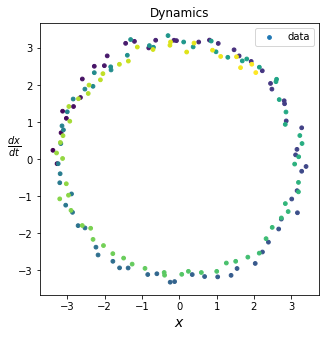

In [0]:
fig = plt.figure(figsize=(5, 5), facecolor='white')
x, y, dx, dy, t = get_trajectory(t_span=[0, 15])
plt.scatter(x,y,c=t,s=14, label='data')

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.show()

Generating Data

In [0]:
data = get_dataset()

Training MLP And HNN Models

In [0]:
base_model = train_MLP(data, epochs=500, learning_rate=0.005)

In [0]:
hnn_model = train_HNN(data, epochs=500, learning_rate=0.005)

### Analysis

In [0]:
t_span = [0,20]
y0 = np.array([1, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
hnn_ivp = integrate_model_HNN(hnn_model, t_span, y0, **kwargs)
base_ivp = integrate_model_MLP(base_model, t_span, y0, **kwargs)

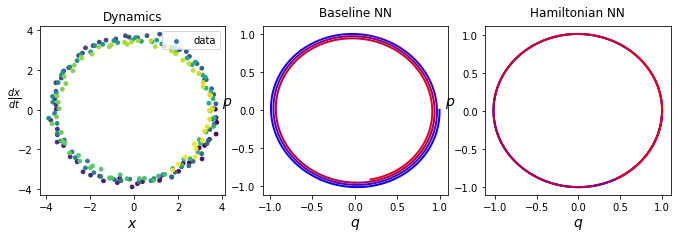

In [0]:
LINE_SEGMENTS = 10
LINE_WIDTH = 2

fig = plt.figure(figsize=(11.3, 3.1), facecolor='white')
fig.add_subplot(1, 3, 1, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0, 20])
plt.scatter(x,y,c=t,s=14, label='data')

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

fig.add_subplot(1, 3, 2, frameon=True)
for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

fig.add_subplot(1, 3, 3, frameon=True)
for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.show()

(2000, 2) (2000, 2) (2000, 2)


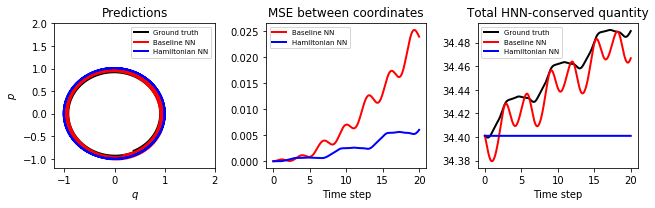

In [0]:
x0 = np.asarray([1, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
print (true_x.shape, base_x.shape, hnn_x.shape)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3])
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-1.2,2) ; plt.ylim(-1.2,2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
# print (((true_x-base_x)**2).mean(-1))
# print (((true_x-hnn_x)**2).mean(-1))
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model.call(tf.Variable(true_x))
base_hq = hnn_model.call(tf.Variable(base_x))
hnn_hq = hnn_model.call(tf.Variable(hnn_x))
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

In [0]:
splits = 5
samples = 3
losses = {'base_energy' : [], 'hnn_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 2000)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    print (true_x.shape, base_x.shape, hnn_x.shape)
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)
(2000, 2) (2000, 2) (2000, 2)


In [0]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )


Baseline NN energy MSE: 1.8441e-01 +/- 4.89e-02
Hamiltonian NN energy MSE: 2.4475e-01 +/- 6.12e-02
